# Imports



In [2]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras import Sequential
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from torchvision import transforms
import tensorflow as tf


# Global functions

In [3]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

def output_metrics(model, X_test, y_test):
    # Use the trained model to make predictions on the test data
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Calculate F1 score
    f1 = f1_score(y_test, y_pred_classes, average='weighted')

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred_classes)

    # Calculate precision
    precision = precision_score(y_test, y_pred_classes, average='weighted')

    # Calculate recall
    recall = recall_score(y_test, y_pred_classes, average='weighted')

    # Print the metrics
    print(f'F1 score: {f1:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'Accuracy: {accuracy:.2f}')


In [4]:
def read_and_resize_image(image_path, size):
    img = cv2.imread(image_path)
    img = cv2.resize(img, size)
    return img

In [5]:
def ShowGrayscaleImage(im, title='', ax=None):
  if ax is None:
    P.figure()
  P.axis('off')

  P.imshow(im, cmap=P.cm.gray, vmin=0, vmax=1)
  P.title(title)

In [6]:
transformer = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
def PreprocessImages(images):
    # assumes input is 4-D, with range [0,255]
    #
    # torchvision have color channel as first dimension
    # with normalization relative to mean/std of ImageNet:
    #    https://pytorch.org/vision/stable/models.html
    images = np.array(images)
    images = images/255
    images = np.transpose(images, (0,3,1,2))
    images = torch.tensor(images, dtype=torch.float32)
    images = transformer.forward(images)
    return images.requires_grad_(True)

In [7]:
def normaliseGradients(image_3d, percentile=99):
    image_2d = np.sum(np.abs(image_3d), axis=2)

    # Get max pixel value in the image
    vmax = np.percentile(image_2d, percentile)
    # Get minimum pixel value in the image
    vmin = np.min(image_2d)

    # Normalise the values. We clip intensities so values lower than 0 are equal 0.
    return np.clip((image_2d - vmin) / (vmax - vmin), 0, 1)

In [8]:
def visualiseImageToHeatmap(image_3d, percentile=99):
    r"""Returns a 3D tensor as RGB 3D heatmap
    Pixels with higher weightage in sailiency heatmap will most saturated and will correspond to high RGB values in output heatmap_rgb
  """
    image_2d = normaliseGradients(image_3d)
    # Create heatmap using "jet" colormap, which returns an RGBA image
    heatmap = plt.get_cmap('jet')(image_2d) * 255

    # Normalise to 0,255 so it's visible when pasted
    return Image.fromarray(heatmap.astype(np.uint8), mode='RGBA'), image_2d

In [9]:
def LoadImage(file_path):
    im = PIL.Image.open(file_path)
    im = im.resize((299, 299))
    im = np.asarray(im)
    return im

In [10]:
def ShowImage(im, title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im)
    P.title(title)

In [11]:
from sklearn import metrics

def plot_confusion_matrix(model_input, test_data, test_labels):
  predictions = model_input.predict(test_data)

  y_pred  = np.argmax(predictions, axis=-1)
  y_test = np.argmax(test_labels, axis=-1)

  confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

  labels = list(set(y_test) | set(y_pred))
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)

  fig, ax = plt.subplots(figsize=(10, 8))
  cm_display.plot(ax=ax)


  plt.show()

# Kaggle dataset loading
 https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000

In [12]:
# !pip install -q kaggle
# from google.colab import files

Upload your kaggle .json api key

In [13]:
# files.upload()

In [14]:
# !mkdir ~/.kaggle

In [15]:
# !cp kaggle.json ~/.kaggle/

In [16]:
# !chmod 600 ~/.kaggle/kaggle.json

In [17]:
# !kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

In [18]:
# !unzip -q skin-cancer-mnist-ham10000.zip -d content

In [19]:
# Removing the zip to save space
# !rm skin-cancer-mnist-ham10000.zip

## Dataset cleaning

In [20]:
df = pd.read_csv('content/HAM10000_metadata')

In [21]:
print(df)

         lesion_id      image_id     dx dx_type   age     sex localization   
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp  \
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp   
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp   
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp   
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear   
...            ...           ...    ...     ...   ...     ...          ...   
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen   
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen   
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen   
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face   
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back   

            dataset  
0      vidir_modern  
1      vidir_modern

In [22]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


In [23]:
df.describe()

,age
count,9958.000000
mean,51.863828
std,16.968614
min,0.000000
25%,40.000000
50%,50.000000
75%,65.000000
max,85.000000


In [24]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Bening keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
ds_dir = 'content/'

In [25]:
from glob import glob
## Let's map the image_id with it's image path from part 1 and part 2 folders
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(ds_dir, '*', '*.jpg'))}

In [26]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get)
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

In [27]:
df.isna().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
dataset           0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

# Training

In [28]:
image_size = (64, 64)

In [29]:
# Apply the function to each image path in the 'path' column of the dataframe
df['image'] = df['path'].apply(lambda x: read_and_resize_image(x, image_size))

In [30]:
df['image'].map(lambda x: x.shape).value_counts()

image
(64, 64, 3)    10015
Name: count, dtype: int64

In [31]:
# Split the data into train and test sets
# We use stratify which splits the dataset with the same class inbalance as the dataset.
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['cell_type_idx'], random_state=42)

In [32]:
# Extract the image data and target labels for train and test sets
# TODO: We're only using images and cell_type_idx, we can experiment with adding more input data
X_train = np.stack(train_df['image'].values)
y_train = train_df['cell_type_idx'].values
X_test = np.stack(test_df['image'].values)
y_test = test_df['cell_type_idx'].values

In [33]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[1], image_size[0], 3)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(df['cell_type_idx'].unique()), activation='softmax'))

In [34]:
model.compile(optimizer = 'adam', loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [35]:
model.fit(X_train, y_train, batch_size=256, epochs=10, validation_split=0.5)

Epoch 1/10
16/16 [==============================] - 15s 883ms/step - loss: 44.0107 - accuracy: 0.4638 - val_loss: 1.1469 - val_accuracy: 0.6553
Epoch 2/10
16/16 [==============================] - 16s 985ms/step - loss: 1.1471 - accuracy: 0.6598 - val_loss: 1.0085 - val_accuracy: 0.6680
Epoch 3/10
16/16 [==============================] - 14s 902ms/step - loss: 0.9707 - accuracy: 0.6747 - val_loss: 0.9315 - val_accuracy: 0.6720
Epoch 4/10
16/16 [==============================] - 13s 817ms/step - loss: 0.8960 - accuracy: 0.6852 - val_loss: 0.9377 - val_accuracy: 0.6760
Epoch 5/10
16/16 [==============================] - 13s 814ms/step - loss: 0.8601 - accuracy: 0.6920 - val_loss: 0.9058 - val_accuracy: 0.6772
Epoch 6/10
16/16 [==============================] - 12s 767ms/step - loss: 0.7844 - accuracy: 0.7199 - val_loss: 0.9163 - val_accuracy: 0.6802
Epoch 7/10
16/16 [==============================] - 12s 753ms/step - loss: 0.7353 - accuracy: 0.7394 - val_loss: 0.8746 - val_accuracy: 0.690

# Metrics

In [36]:
output_metrics(model, X_test, y_test)

63/63 [==============================] - 1s 21ms/step
F1 score: 0.64
Precision: 0.64
Recall: 0.69
Accuracy: 0.69


In [37]:
# Create a new DataFrame with 'lesion_id' and 'cell_type_dx' columns from the test data
result_df = pd.DataFrame({'lesion_id': test_df['lesion_id'], 'target': y_test})

# Smoothgrad


In [38]:
import torch
import PIL.Image
from torchvision import models, transforms
from matplotlib import pylab as P

In [39]:
class_idx_str = 'class_idx_str'

In [40]:
INPUT_OUTPUT_GRADIENTS = 'INPUT_OUTPUT_GRADIENTS'
CONVOLUTION_LAYER_VALUES = 'CONVOLUTION_LAYER_VALUES'
CONVOLUTION_OUTPUT_GRADIENTS = 'CONVOLUTION_OUTPUT_GRADIENTS'

In [41]:
expected_keys = [INPUT_OUTPUT_GRADIENTS]

In [42]:
conv_layer_outputs = {}

In [43]:
def call_model_function(images, call_model_args=None, expected_keys=None):
    target_class_idx =  call_model_args[class_idx_str]
    images = tf.convert_to_tensor(images)
    with tf.GradientTape() as tape:
        if expected_keys==[INPUT_OUTPUT_GRADIENTS]:
            tape.watch(images)
            _, output_layer = new_model(images)
            output_layer = output_layer[:,target_class_idx]
            gradients = np.array(tape.gradient(output_layer, images))
            return {INPUT_OUTPUT_GRADIENTS: gradients}
        else:
            conv_layer, output_layer = new_model(images)
            gradients = np.array(tape.gradient(output_layer, conv_layer))
            return {CONVOLUTION_LAYER_VALUES: conv_layer,
                    CONVOLUTION_OUTPUT_GRADIENTS: gradients}

In [44]:
def format_and_check_call_model_output(self, output, input_shape, expected_keys):
  """Converts keys in the output into an np.ndarray, and confirms its shape.

  Args:
    output: The output dictionary of data to be formatted.
    input_shape: The shape of the input that yielded the output
    expected_keys: List of keys inside output to format/check for shape agreement.

  Raises:
      ValueError: If output shapes do not match expected shape."""
  # If key is in check_full_shape, the shape should be equal to the input shape (e.g. 
  # INPUT_OUTPUT_GRADIENTS, which gives gradients for each value of the input). Otherwise,
  # only checks the outermost dimension of output to match input_shape (i.e. the batch size
  # should be the same).
  check_full_shape = [INPUT_OUTPUT_GRADIENTS]
  for expected_key in expected_keys:
    output[expected_key] = np.asarray(output[expected_key])
    expected_shape = input_shape
    actual_shape = output[expected_key].shape
    if expected_key not in check_full_shape:
      expected_shape = expected_shape[0]
      actual_shape = actual_shape[0]
    if expected_shape != actual_shape:
      raise ValueError(SHAPE_ERROR_MESSAGE[expected_key].format(
                      expected_shape, actual_shape))

In [45]:
"""Utilities to compute SaliencyMasks."""
import numpy as np


# Output of the last convolution layer for the given input, including the batch
# dimension.
CONVOLUTION_LAYER_VALUES = 'CONVOLUTION_LAYER_VALUES'
# Gradients of the output being explained (the logit/softmax value) with respect
# to the last convolution layer, including the batch dimension.
CONVOLUTION_OUTPUT_GRADIENTS = 'CONVOLUTION_OUTPUT_GRADIENTS'
# Gradients of the output being explained (the logit/softmax value) with respect
# to the input. Shape should be the same shape as x_value_batch.
INPUT_OUTPUT_GRADIENTS = 'INPUT_OUTPUT_GRADIENTS'
# Value of the output being explained (the logit/softmax value).
OUTPUT_LAYER_VALUES = 'OUTPUT_LAYER_VALUES'

SHAPE_ERROR_MESSAGE = {
    CONVOLUTION_LAYER_VALUES: (
        'Expected outermost dimension of CONVOLUTION_LAYER_VALUES to be the '
        'same as x_value_batch - expected {}, actual {}'
    ),
    CONVOLUTION_OUTPUT_GRADIENTS: (
        'Expected outermost dimension of CONVOLUTION_OUTPUT_GRADIENTS to be the '
        'same as x_value_batch - expected {}, actual {}'
    ),
    INPUT_OUTPUT_GRADIENTS: (
        'Expected key INPUT_OUTPUT_GRADIENTS to be the same shape as input '
        'x_value_batch - expected {}, actual {}'
    ),
    OUTPUT_LAYER_VALUES: (
        'Expected outermost dimension of OUTPUT_LAYER_VALUES to be the same as'
        ' x_value_batch - expected {}, actual {}'
    ),
}


class CoreSaliency(object):
  r"""Base class for saliency methods. Alone, this class doesn't do anything."""

  def GetMask(self, x_value, call_model_function, call_model_args=None):
    """Returns an unsmoothed mask.

    Args:
      x_value: Input ndarray.
      call_model_function: A function that interfaces with a model to return
        specific output in a dictionary when given an input and other arguments.
        Expected function signature:
        - call_model_function(x_value_batch,
                              call_model_args=None,
                              expected_keys=None):
          x_value_batch - Input for the model, given as a batch (i.e. dimension
            0 is the batch dimension, dimensions 1 through n represent a single
            input).
          call_model_args - Other arguments used to call and run the model.
          expected_keys - List of keys that are expected in the output. Possible
            keys in this list are CONVOLUTION_LAYER_VALUES, 
            CONVOLUTION_OUTPUT_GRADIENTS, INPUT_OUTPUT_GRADIENTS, and
            OUTPUT_LAYER_VALUES, and are explained in detail where declared.
      call_model_args: The arguments that will be passed to the call model
        function, for every call of the model.

    """
    raise NotImplementedError('A derived class should implemented GetMask()')

  def GetSmoothedMask(self,
                      x_value,
                      call_model_function,
                      call_model_args=None,
                      stdev_spread=.15,
                      nsamples=25,
                      magnitude=True,
                      **kwargs):
    """Returns a mask that is smoothed with the SmoothGrad method.

    Args:
      x_value: Input ndarray.
      call_model_function: A function that interfaces with a model to return
        specific output in a dictionary when given an input and other arguments.
        Expected function signature:
        - call_model_function(x_value_batch,
                              call_model_args=None,
                              expected_keys=None):
          x_value_batch - Input for the model, given as a batch (i.e. dimension
            0 is the batch dimension, dimensions 1 through n represent a single
            input).
          call_model_args - Other arguments used to call and run the model.
          expected_keys - List of keys that are expected in the output. Possible
            keys in this list are CONVOLUTION_LAYER_VALUES,
            CONVOLUTION_OUTPUT_GRADIENTS, INPUT_OUTPUT_GRADIENTS, and
            OUTPUT_LAYER_VALUES, and are explained in detail where declared.
      call_model_args: The arguments that will be passed to the call model
        function, for every call of the model.
      stdev_spread: Amount of noise to add to the input, as fraction of the
                    total spread (x_max - x_min). Defaults to 15%.
      nsamples: Number of samples to average across to get the smooth gradient.
      magnitude: If true, computes the sum of squares of gradients instead of
                 just the sum. Defaults to true.
    """
    stdev = stdev_spread * (np.max(x_value) - np.min(x_value))

    total_gradients = np.zeros_like(x_value, dtype=np.float32)
    for _ in range(nsamples):
      noise = np.random.normal(0, stdev, x_value.shape)
      x_plus_noise = x_value + noise
      grad = self.GetMask(x_plus_noise, call_model_function, call_model_args,
                          **kwargs)
      if magnitude:
        total_gradients += (grad * grad)
      else:
        total_gradients += grad

    return total_gradients / nsamples

  def format_and_check_call_model_output(self, output, input_shape, expected_keys):
    """Converts keys in the output into an np.ndarray, and confirms its shape.

    Args:
      output: The output dictionary of data to be formatted.
      input_shape: The shape of the input that yielded the output
      expected_keys: List of keys inside output to format/check for shape agreement.

    Raises:
        ValueError: If output shapes do not match expected shape."""
    # If key is in check_full_shape, the shape should be equal to the input shape (e.g. 
    # INPUT_OUTPUT_GRADIENTS, which gives gradients for each value of the input). Otherwise,
    # only checks the outermost dimension of output to match input_shape (i.e. the batch size
    # should be the same).
    check_full_shape = [INPUT_OUTPUT_GRADIENTS]
    for expected_key in expected_keys:
      output[expected_key] = np.asarray(output[expected_key])
      expected_shape = input_shape
      actual_shape = output[expected_key].shape
      if expected_key not in check_full_shape:
        expected_shape = expected_shape[0]
        actual_shape = actual_shape[0]
      if expected_shape != actual_shape:
        raise ValueError(SHAPE_ERROR_MESSAGE[expected_key].format(
                       expected_shape, actual_shape))


In [46]:
"""Utilities to compute saliency by returning the output gradients."""

import numpy as np


class GradientSaliency(CoreSaliency):
  """A CoreSaliency class that computes saliency masks with gradients."""

  expected_keys = [INPUT_OUTPUT_GRADIENTS]

  def GetMask(self, x_value, call_model_function, call_model_args=None):
    """Returns a vanilla gradients mask.

    Args:
      x_value: Input ndarray.
      call_model_function: A function that interfaces with a model to return
        specific data in a dictionary when given an input and other arguments.
        Expected function signature:
        - call_model_function(x_value_batch,
                              call_model_args=None,
                              expected_keys=None):
          x_value_batch - Input for the model, given as a batch (i.e. dimension
            0 is the batch dimension, dimensions 1 through n represent a single
            input).
          call_model_args - Other arguments used to call and run the model.
          expected_keys - List of keys that are expected in the output. For this
            method (Gradients), the expected keys are
            INPUT_OUTPUT_GRADIENTS - Gradients of the output layer
              (logit/softmax) with respect to the input. Shape should be the
              same shape as x_value_batch.
      call_model_args: The arguments that will be passed to the call model
        function, for every call of the model.
    """
    x_value_batched = np.expand_dims(x_value, axis=0)
    call_model_output = call_model_function(
        x_value_batched,
        call_model_args=call_model_args,
        expected_keys=self.expected_keys)

    self.format_and_check_call_model_output(call_model_output,
                                            x_value_batched.shape,
                                            self.expected_keys)

    return call_model_output[INPUT_OUTPUT_GRADIENTS][0]


# Application

In [47]:
heatmap_images = []
raw_gradients = []

In [48]:
last_conv_layer = model.get_layer(index=-3)
new_model = tf.keras.models.Model(inputs=model.input, 
                                   outputs=[last_conv_layer.output, model.output])

In [49]:
smoothgrad = GradientSaliency()

In [50]:
images = df['path']

In [51]:
from PIL import Image

In [52]:
predictions = model.predict(X_test)

63/63 [==============================] - 1s 22ms/step


In [53]:
baseline = np.zeros(image_size)
prediction_class = np.argmax(predictions[0])
call_model_args = {class_idx_str: prediction_class}
gradient_saliency = GradientSaliency()

In [54]:
for img in images[:100]:
  img_arr = read_and_resize_image(image_path=img, size=image_size)
  im_tensor = PreprocessImages([img_arr])
  im = img_arr.astype(np.float32)
  smoothgrad = GradientSaliency()
  vanilla_integrated_gradients_mask_3d = smoothgrad.GetSmoothedMask(
    im, call_model_function, call_model_args)
  raw_gradients.append(vanilla_integrated_gradients_mask_3d)
  heatmap_images.append(visualiseImageToHeatmap(vanilla_integrated_gradients_mask_3d))

In [55]:
def convert_to_boolean_mask(image):
    # Convert the image to a NumPy array
    image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)

    # Create a boolean mask where white pixels are True and black pixels are False
    binary_image = np.where(image == 255, True, False)  # Assuming white pixels are represented as 255

    cropped_image = cv2.resize(binary_image.astype(np.uint8), (64, 64))

    return cropped_image

In [56]:
def load_images_from_folder(folder_path):
    image_paths = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        if os.path.isfile(img_path):
            image_paths.append(img_path)
    return image_paths

In [57]:
folder_path = 'content/HAM10000_segmentations_lesion_tschandl/HAM10000_segmentations_lesion_tschandl'
image_list = load_images_from_folder(folder_path)

In [58]:
segment_images = load_images_from_folder(folder_path)

In [59]:
boolean_masks = []
for img in image_list:
    boolean_masks.append(convert_to_boolean_mask(img))

In [60]:
print(boolean_masks[0])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [61]:
print(len(heatmap_images))
print(len(raw_gradients))
print(len(boolean_masks))
print(len(segment_images))

100
100
10015
10015


In [62]:
def calculate_overlap(g, m) -> float:
    # Invert the mask, so the pixels outside are True.
    m[:] = ~m
    # Replace where the mask is False, with a 0 in the same location in raw_gradients
    segment = np.where(np.array(m), np.array(g), 0)
    # We now have just the gradients in a 2D vector of the pixels outside the bounding box
    sum_mask_segment = np.sum(segment)
    # Find what percentage the outside pixels make up of the full gradient image by summing both 2D vectors
    total_sum = np.sum(g)
    # What percentage are the gradients outside the segment of the full gradient vector
    overlap = (sum_mask_segment / total_sum) * 100

    return overlap

In [70]:
overlap = []
for i in range(len(raw_gradients)):
    overlap.append([calculate_overlap(raw_gradients[i][:, :, 0], boolean_masks[i]), np.argmax(predictions, axis=1)[i]])

[4 4 4 ... 4 4 4]


<Figure size 1000x600 with 0 Axes>

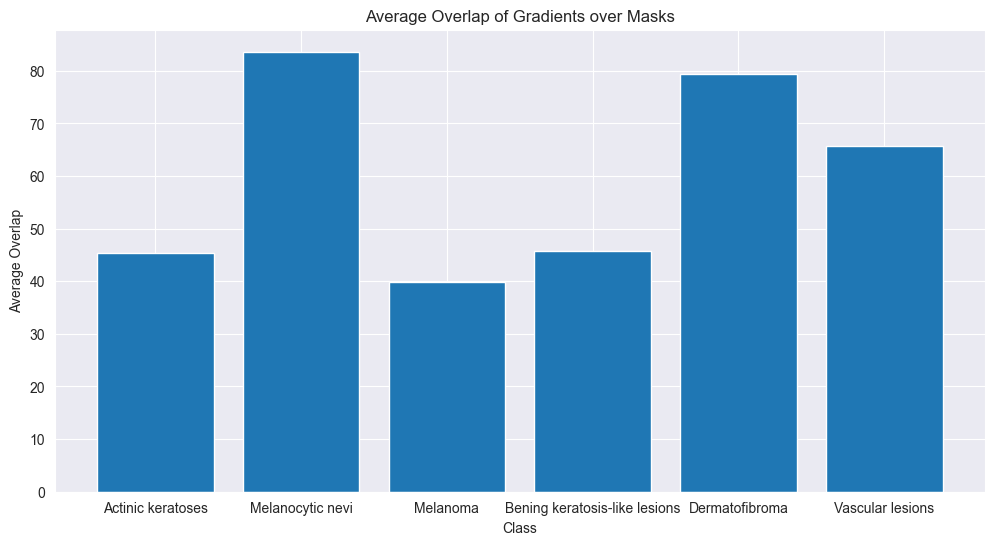

In [85]:
from collections import defaultdict

# Calculate average overlap for each class
class_overlaps = defaultdict(list)
for item in overlap:
    overlap_value = item[0]
    class_label = item[1]
    class_overlaps[class_label].append(overlap_value)

class_labels = []
average_overlaps = []

for class_label, overlaps in class_overlaps.items():
    class_labels.append(class_label)
    average_overlap = sum(overlaps) / len(overlaps)
    average_overlaps.append(average_overlap)

# Create a bar chart or scatter plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as per your preference

mapped_labels = [list(lesion_type_dict.values())[label] for label in class_labels]

plt.figure(figsize=(12, 6))
# Bar chart
plt.bar(range(len(average_overlaps)), average_overlaps)
plt.xticks(range(len(average_overlaps)), mapped_labels)
plt.xlabel('Class')
plt.ylabel('Average Overlap')
plt.title('Average Overlap of Gradients over Masks')

plt.show()